# GWAS with the 1000 Genomes TileDB-VCF Dataset

In this notebook we'll perform a rudimentary genome-wide association study using the 1000 Genomes (1KG) dataset. The goal of this tutorial is to demonstrate the mechanics of performing genome-wide analyses using variant call data stored with TileDB-VCF and how such analyses can be easily scaled using TileDB Cloud's serverless computation platform.

To get started we'll load a few required packages and define several variables that we'll refer to throughout the notebook.

In [1]:
# tiledb-vcf and tiledb-cloud
import tiledbvcf, tiledb, tiledb.cloud
from tiledb.cloud.compute import Delayed
import pandas as pd

# genomic regions
import pybedtools as pbt

# statistical methods
import numpy as np
import scipy.stats as stats

# visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# variables
genome = "hg19"
array_uri = "tiledb://TileDB-Inc/vcf-1kg-phase3"
array_uri = "s3://genomic-datasets/notebooks/1kgp3/1kgp3-array"
sample_data_file = "https://1000genomes.s3.us-east-1.amazonaws.com/release/20130502/integrated_call_samples_v3.20130502.ALL.panel"

In [2]:
tiledbvcf.version

'0.8.2'

In [5]:
# Grant S3 Access
import os
from envbash import load_envbash
load_envbash('env.bash')

tiledb_config = [
    f"vfs.s3.aws_access_key_id={os.getenv('TILEDB_VFS_S3_AWS_ACCESS_KEY_ID')}",
    f"vfs.s3.aws_secret_access_key={os.getenv('TILEDB_VFS_S3_SECRET_ACCESS_KEY')}"
]

# Sample Phenotypes

Because no phenotypic data was collected for the 1KG dataset, we'll create a dummy trait indicating whether or not a sample identified as female. The results of this analysis will not likely be publishable.

In [6]:
df_samples = (pd.read_csv(
    sample_data_file, 
    sep = "\t", 
    index_col = "sample")
  .dropna(axis='columns', how='all')
)

# dummy trait
df_samples["is_female"] = df_samples.gender == "female"
df_samples

,pop,super_pop,gender,is_female
sample,,,,
HG00096,GBR,EUR,male,False
HG00097,GBR,EUR,female,True
HG00099,GBR,EUR,female,True
HG00100,GBR,EUR,female,True
HG00101,GBR,EUR,male,False
...,...,...,...,...
NA21137,GIH,SAS,female,True
NA21141,GIH,SAS,female,True
NA21142,GIH,SAS,female,True


# Single Node

In this section we'll walk through the steps required for this analysis on a single machine.

First we create the TileDB-VCF `Dataset` object pointing to the 1KG array on TileDB Cloud and pass in a few parameters to provide the necessary credentials and update our memory budget.

In [7]:
cfg = tiledbvcf.ReadConfig(
    memory_budget_mb = 2048,
    sort_regions = False, 
    tiledb_config = tiledb_config
)

ds = tiledbvcf.Dataset(array_uri, mode = "r", cfg = cfg, stats = True, verbose = True)
ds

## Query Region Data

Let's query the TileDB-VCF dataset and create a Pandas Dataframe containing the variant data for the proximal tip of chromosome 1 across all 2,504 samples. We'll also specify the attributes to retrieve that are needed in the subsequent filtering and analysis steps.

In [15]:
attrs = [
    "sample_name", 
    "contig",
    "pos_start",
    "pos_end", 
    "info_VT", 
    "info_MULTI_ALLELIC", 
    "fmt_GT"
]

In [100]:
df_vars = ds.read(
    attrs = attrs, 
    regions = ['1:1-1000000']
)

In [101]:
df_vars

,sample_name,contig,pos_start,pos_end,info_VT,info_MULTI_ALLELIC,fmt_GT
0,HG00096,1,10177,10177,INDEL,None,"[1, 0]"
1,HG00097,1,10177,10177,INDEL,None,"[0, 1]"
2,HG00099,1,10177,10177,INDEL,None,"[0, 1]"
3,HG00100,1,10177,10177,INDEL,None,"[1, 0]"
4,HG00102,1,10177,10177,INDEL,None,"[1, 0]"
...,...,...,...,...,...,...,...
5959401,NA12156,1,1900432,1900432,SNP,None,"[0, 1]"
5959402,NA12234,1,1900432,1900432,SNP,None,"[1, 0]"
5959403,NA12272,1,1900432,1900432,SNP,None,"[0, 1]"
5959404,NA12273,1,1900432,1900432,SNP,None,"[0, 1]"


## Variant Filtering

We're going to focus on bi-allelic SNPs for the association test so we'll need to filter the results to sites that meet this criteria. 

In [104]:
# remove multi-allelic sites and filter for SNPs
df_vars = (df_vars
    .query("info_MULTI_ALLELIC.isna()", engine = "python")
    .query("info_VT == 'SNP'")
)

Next we'll recode the genotypes to integers representing the heterozygous and homozygous major/minor allele homozygous  groups.

In [105]:
# calculate allele dose
df_vars["dose"] = df_vars.fmt_GT.apply(sum, convert_dtype = False)

Using the new `"dose"` column, we can calculate the allele count and minor allele frequency. 

In [106]:
# calculate minor allele frequencies
df_snps = (df_vars
    .groupby(['contig', "pos_start"])
    .agg(
        info_AC = pd.NamedAgg(
            column = "dose", 
            aggfunc = lambda x: sum(x == 1) + (sum(x == 2) * 2)
        )
    )
)

df_snps["info_AF"] = df_snps.info_AC.apply(func = lambda x: (x / df_samples.shape[0]) / 2)

Here we'll examine the distribution of minor allele frequencies to verify the validity of the calculations.

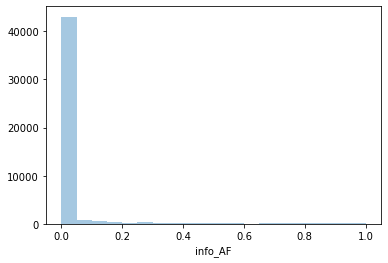

In [107]:
sns.distplot(df_snps.info_AF, hist = True, kde = False, bins = 20)

Then we'll filter our dataset to include only variants with an allele frequency between 5 and 95%.

In [108]:
# remove sites with MAF < 5%
df_snps = df_snps.query("info_AF >= 0.05 and info_AF <= 0.95")

df_vars.set_index(keys = ["contig", "pos_start"], inplace = True)
df_vars = df_vars[df_vars.index.isin(df_snps.index)]

df_vars

sample_name  pos_end info_VT info_MULTI_ALLELIC  fmt_GT dose
contig pos_start                                                             
1      11008         HG00102    11008     SNP               None  [0, 1]    1
       11008         HG00103    11008     SNP               None  [0, 1]    1
       11012         HG00102    11012     SNP               None  [0, 1]    1
       11012         HG00103    11012     SNP               None  [0, 1]    1
       13116         HG00097    13116     SNP               None  [1, 0]    1
...                      ...      ...     ...                ...     ...  ...
       1900432       NA12156  1900432     SNP               None  [0, 1]    1
       1900432       NA12234  1900432     SNP               None  [1, 0]    1
       1900432       NA12272  1900432     SNP               None  [0, 1]    1
       1900432       NA12273  1900432     SNP               None  [0, 1]    1
       1900432       NA12275  1900432     SNP               None  [1, 0]    1

[4213516 rows x 6 columns]

## Association Analysis

For the actual analysis we need to reshape the variant data to a wide format, in which each genotype is indexed by it's genomic positon and sample. 

In [110]:
# convert to wide format
df_wide = (df_vars[["sample_name", "dose"]]
               .pivot(columns = "sample_name")
               .fillna(0)
          )
df_wide

dose                                                  \
sample_name      HG00096 HG00097 HG00099 HG00100 HG00101 HG00102 HG00103   
contig pos_start                                                           
1      11008           0       0       0       0       0       1       1   
       11012           0       0       0       0       0       1       1   
       13116           0       1       0       0       1       0       0   
       13118           0       1       0       0       1       0       0   
       13273           0       0       0       0       0       0       0   
...                  ...     ...     ...     ...     ...     ...     ...   
       1903357         1       0       0       0       2       0       2   
       1903712         0       0       1       2       0       1       0   
       1904767         0       0       0       0       0       0       0   
       1905131         0       0       0       0       0       0       0   
       1905790         1       0       0       0       2       0       2   

                                          ...                                  \
sample_name      HG00105 HG00106 HG00107  ... NA21128 NA21129 NA21130 NA21133   
contig pos_start                          ...                                   
1      11008           0       0       0  ...       0       0       0       0   
       11012           0       0       0  ...       0       0       0       0   
       13116           1       0       1  ...       1       1       0       0   
       13118           1       0       1  ...       1       1       0       0   
       13273           0       1       0  ...       0       0       0       0   
...                  ...     ...     ...  ...     ...     ...     ...     ...   
       1903357         0       1       1  ...       0       0       0       0   
       1903712         1       0       0  ...       0       0       0       0   
       1904767         0       0       0  ...       0       0       0       0   
       1905131         0       0       0  ...       0       0       0       0   
       1905790         0       1       1  ...       0       0       0       0   

                                                                  
sample_name      NA21135 NA21137 NA21141 NA21142 NA21143 NA21144  
contig pos_start                                                  
1      11008           0       1       1       1       0       0  
       11012           0       1       1       1       0       0  
       13116           1       2       0       0       0       0  
       13118           1       2       0       0       0       0  
       13273           0       0       0       0       1       0  
...                  ...     ...     ...     ...     ...     ...  
       1903357         0       0       0       0       0       0  
       1903712         0       0       0       0       0       0  
       1904767         0       0       0       0       0       0  
       1905131         0       0       0       0       0       0  
       1905790         0       0       0       0       0       0  

[3594 rows x 2504 columns]

We'll also recode the genotypes in order to split our samples into two groups based on the presence of a minor allele.

In [111]:
# code genotypes based on whether they are homo- or heterozygous for the minor allele
df_wide = df_wide.apply(func = lambda x: x > 0, axis = "columns")

# count allele dosage at each site
dose_counts = df_wide.apply(pd.value_counts, axis = 1).fillna(0)
dose_counts

False  True 
contig pos_start              
1      11008       2082    422
       11012       2082    422
       13116       2054    450
       13118       2054    450
       13273       2044    460
...                 ...    ...
       1903357     1958    546
       1903712     1729    775
       1904767     2188    316
       1905131     2195    309
       1905790     1899    605

[3594 rows x 2 columns]

Finally we'll run the actual analysis, performing a Fisher's Exact Test at each of the sites that our filtering criteria.

In [114]:
# create empty dataframe to store the results
df_results = pd.DataFrame(
    columns = ["contig", "pos_start", "oddsratio", "pvalue"]
)

# iterate across all filtered sites
for pos,snp in df_wide.iterrows():

    counts = pd.crosstab(
        index = df_samples.is_female, 
        columns = pd.Categorical(snp.dose.rename("genotype"), categories = [True, False])
    )
    
    oddsratio,pvalue = stats.fisher_exact(counts, alternative = "two-sided")

    result = dict(zip(
        ["contig", "pos_start", "oddsratio", "pvalue"], 
        [pos[0], pos[1], oddsratio, pvalue])
    )

    df_results = df_results.append(result, ignore_index = True)

df_results

,contig,pos_start,oddsratio,pvalue
0,1,11008,0.925366,0.487764
1,1,11012,0.925366,0.487764
2,1,13116,0.921018,0.435365
3,1,13118,0.921018,0.435365
4,1,13273,1.106409,0.352892
...,...,...,...,...
3589,1,1903357,0.853648,0.110187
3590,1,1903712,1.191099,0.046706
3591,1,1904767,1.065787,0.630243
3592,1,1905131,1.090159,0.503973


And no association test would be complete without a manhattan plot:

[Text(0, 0.5, '-log10 p-value'), Text(0.5, 0, 'Chr 1 Position')]

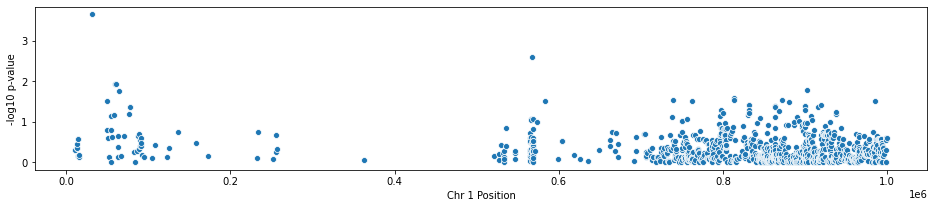

In [20]:
df_results["log_pvalue"] = -np.log10(df_results.pvalue)

plt.figure(figsize = (16, 3))

ax = sns.scatterplot(
    x = "pos_start", 
    y = "log_pvalue", 
    data = df_results
)

ax.set(xlabel = "Chr 1 Position", ylabel = "-log10 p-value")

# Scaling GWAS with Serverless UDFs

Let's look at how we can easily scale genome-wide analyses by leveraging TileDB Cloud's serverless compute platform. We can parallelize the association analysis by splitting-up the genome into disjoint sections that are each queried, filtered, and analyzed by a different node, all without having to manage any servers.

## Binned Genomic Regions

To get started we'll use the handy functionality provided by [pybedtools](https://daler.github.io/pybedtools/) for dividing a genome into windows (i.e., bins). We simply indicate which genome we're working with and how large each window should be.

In [8]:
window = 100000
genome_bins = pbt.BedTool().window_maker(genome = genome, w = window)
genome_bins.head()

chr1	0	100000
 chr1	100000	200000
 chr1	200000	300000
 chr1	300000	400000
 chr1	400000	500000
 chr1	500000	600000
 chr1	600000	700000
 chr1	700000	800000
 chr1	800000	900000
 chr1	900000	1000000
 

For now we'll filter this list of regions to include only the first chromosome. Then we need to coerce the `Bedtool` object into a list of regions in the `chr:start-end` format that `tiledbvcf` expects.

In [9]:
regions_df = genome_bins.to_dataframe().query("chrom == 'chr1'")

# modify contig naming scheme to match the dataset 
regions_df.chrom = regions_df.chrom.apply(lambda x: x.lstrip("chr"))

bed_regions = (regions_df
    .apply(lambda x: f"{x['chrom']}:{x['start']}-{x['end']}", axis = 1)
    .tolist()
)

bed_regions[:5]

['1:0-100000',
 '1:100000-200000',
 '1:200000-300000',
 '1:300000-400000',
 '1:400000-500000']

## Define GWAS Functions

Each of the individual tasks we performed above must be wrapped in functions so they can be packaged as UDFs and shipped to the serverless compute infrastructure. We'll define two separate functions:
1. `query_region()` extracts a specified window from the genome and then filters the sites based on the defined criteria
2. `calc_gwas()` reshapes the Dataframe of variants into a variant by sample matrix and performs a chi-squared analysis on site for the included trait
3. `combine_results()` Combines the individual GWAS results for each region into a single DataFrame

In [16]:
"""
Query region for bi-allelic SNPs

:param uri: URI of TileDB-VCF dataset
:param list of str attrs: List of attribute names to be read
:param list of str region: Genomic region to be read
:param memory_budget_mb: Query memory budget
:param tiledb_config: List of strings of format 'option=value'
"""

def query_region(uri, attrs, region, memory_budget_mb, tiledb_config):
    print(f"Querying region {region} in array {uri}")
    
    cfg = tiledbvcf.ReadConfig(
        memory_budget_mb = memory_budget_mb, 
        sort_regions = False,
        tiledb_config = tiledb_config
    )
    ds = tiledbvcf.Dataset(uri, mode = "r", cfg = cfg, verbose = True, stats = True)

    df_vars = ds.read(attrs, regions = region)
    print(ds.tiledb_stats())
    print(f"Retrieved {df_vars.shape[0]} records from the array")


    # remove multi-allelic sites and filter for SNPs
    df_vars = (df_vars
        .query("info_MULTI_ALLELIC.isna()", engine = "python")
        .query("info_VT == 'SNP'")
    )
    print(f"Returning {df_vars.shape[0]} bi-allelic SNPs")
    
    # calculate allele dose
    df_vars["dose"] = df_vars.fmt_GT.apply(sum, convert_dtype = False)
    
    return df_vars
    

In [15]:
tiledb.cloud.udf.register_generic_udf(func = query_region, namespace = "aaronwolen", name = "Query Region")

Exception: [InternalError: failed to parse or message missing from ApiException]

In [11]:
"""
Filter variants by allele frequencies

:param pandas dataFrame df: DataFrame of variants with the following fields: 
    'sample_name', contig', 'pos_start', and 'dose'
:param tuple maf: Tuple containing the upper- and lower-bounds of acceptable minor allele frequencies
"""

def filter_variants(df, maf):
    print(f"Filtering {df.shape[0]} variants")
    if df.shape[0] == 0: 
        return df
        
    # calculate minor allele frequencies
    nsamples = len(pd.unique(df.sample_name))
    df_snps = (df
        .groupby(['contig', "pos_start"])
        .agg(
            info_AC = pd.NamedAgg(
                column = "dose", 
                aggfunc = lambda x: sum(x == 1) + (sum(x == 2) * 2)
            )
        )
    )

    df_snps["info_AF"] = df_snps.info_AC.apply(func = lambda x: (x / nsamples) / 2)
    
    # filter sites by MAF
    df_snps = df_snps.query(f"info_AF >= {maf[0]} and info_AF <= {maf[1]}")
    df.set_index(keys = ["contig", "pos_start"], inplace = True)
    df = df[df.index.isin(df_snps.index)]    
    print(f"Selected {df.shape[0]} variants")
    
    return df

In [12]:
"""
Calculate GWAS

Perform an association analysis on variants queried from a TileDB-VCF dataset.

:param pandas dataFrame df: DataFrame containing variants for association analysis
    Must contain the following columns: contig, pos_start, sample_name, and dose
:param pandas series trait: Series object indexed by sample names containing the trait of interest
"""
def calc_gwas(df, trait):
    print(f"Performing association analysis across {df.shape[0]} variants")
    
    # create empty dataframe to store the results
    df_results = pd.DataFrame(
        columns = ["contig", "pos_start", "oddsratio", "pvalue"]
    )
    
    if df.shape[0] == 0: 
        return df_results
    
    # ensure all sample names are shared in trait and variants
    trait = trait[trait.index.isin(df.sample_name)]

    # convert to wide format
    df_wide = (df[["sample_name", "dose"]]
                   .pivot(columns = "sample_name")
                   .fillna(0)
              )
    
    # code genotypes based on whether they are homo- or heterozygous for the minor allele
    df_wide = df_wide.apply(func = lambda x: x > 0, axis = "columns")
    

    # iterate across all sites
    for pos,snp in df_wide.iterrows():

        counts = pd.crosstab(
            index = trait, 
            columns = pd.Categorical(snp.dose.rename("genotype"), categories = [True, False]),
            dropna = False
        )

        oddsratio,pvalue = stats.fisher_exact(counts, alternative = "two-sided")

        result = dict(zip(
            ["contig", "pos_start", "oddsratio", "pvalue"], 
            [pos[0], pos[1], oddsratio, pvalue])
        )

        df_results = df_results.append(result, ignore_index = True)

    return df_results

In [13]:
"""
Combine GWAS Results

:param list of dataframes: Region-specific GWAS results to combine
"""

def combine_results(dfs):
    print(f"Input list contains {len(dfs)} items")
    return pd.concat(dfs)

## Create and Execute Distributed GWAS

We then need to create Delayed versions of these functions with the appropriate parameters. For `query_region()` we need to create one delayed instance for each of the genomic regions to be queried. 

In [16]:
local = False

delayed_queries = []
for r in bed_regions[:10]:
    delayed_queries.append(
        Delayed(query_region, local = local)(
            uri = array_uri, 
            attrs = attrs, 
            region = [r],
            memory_budget_mb = 1024,
            tiledb_config = tiledb_config
        )
    )

delayed_filter = [Delayed(filter_variants, local = local)(df = q, maf = (0.05, 0.95)) for q in delayed_queries] 
delayed_gwas = [Delayed(calc_gwas, local = local)(df = q, trait = df_samples.is_female) for q in delayed_filter]
delayed_results = Delayed(combine_results, local = local)(delayed_gwas)

We can visualize our UDF pipeline as a task graph. Note the color of each node will update in real time as the UDFs are processed, so it's handy to track the progress of your analysis.

In [17]:
delayed_results.visualize(force_plotly = True)

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 0.5},
     …

Finally, we can execute our distributed GWAS and collect the results.

In [ ]:
results = delayed_results.compute()

[Text(0, 0.5, '-log10 p-value'), Text(0.5, 0, 'Chr 1 Position')]

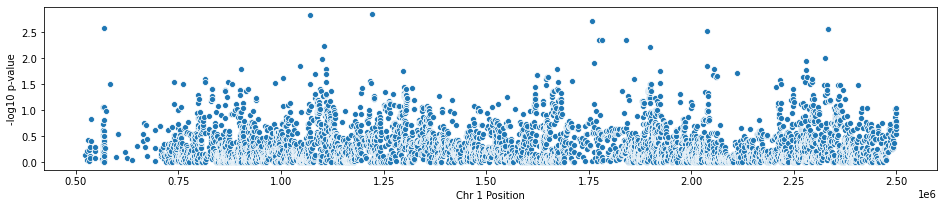

In [26]:
results["log_pvalue"] = -np.log10(results.pvalue)

plt.figure(figsize = (16, 3))

ax = sns.scatterplot(
    x = "pos_start", 
    y = "log_pvalue", 
    data = results
)

ax.set(xlabel = "Chr 1 Position", ylabel = "-log10 p-value")

## Summary

Here we've demonstrated how genome-wide pipelines can be encapsulated as distinct tasks, distributed as UDFs, and easily deployed in parallel at scale, all without having to manage your own cluster.